# Multi-year eddy detection and NPP averaging
    - Calculates cyclonic and anticyclonic eddies 
    - In cell [2]: 
        - Specify length scale for high-pass filtering
        - Specify minimum SSH for eddy detection
        - Specify the domain of analysis (lon, lat) box
    - The mean NPP values for eddies will be recorded as NPP_Cyclonic_YYYYMMDD.nc, NPP_Anticyclonic_YYYYMMDD.nc
    - The eddy location, size, etc will be recorded as Cyclonic_YYYYMMDD.nc, NPP_Anticyclonic_YYYYMMDD.nc

In [1]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
import xarray as xr
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
# extent of the domain: [X0, X1, Y0, Y1]
extent = [200, 240, 42, 62] # This is the whole domain
domain = 'whole'
# spatial length scale: L, km
Lcutoff = 500
# minimum ssh for eddy detection, m
sshmin = 0.06

In [3]:
def get_ssh(year,date,ext):
    ds=xr.open_dataset(f'/glade/campaign/univ/ugit0036/obs/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_{year}.nc')
    ds1=ds.sel(time=date,method='nearest')
    x=ds['longitude']+360
    ds1['longitude']=x
    ds2=ds1.sel(longitude=slice(ext[0],ext[1])).sel(latitude=slice(ext[2],ext[3]))
    ds2.to_netcdf('ssh.nc')
    return 1

In [4]:
def get_npp(year,date,ext):
    ds=xr.open_dataset('/glade/campaign/univ/ugit0036/obs/npp_CbPM-MODIS_8day_GOA.nc')
    ds1=ds.sel(time=date,method='nearest')
    x=ds1['lon'].to_numpy()+360
    ds1['lon']=x
    ds2=ds1.sel(lon=slice(ext[0],ext[1])).sel(lat=slice(ext[2],ext[3]))
    ds2.to_netcdf('npp.nc')

In [5]:
def combine_ssh_npp(filename_alt,filename_npp):
    var_name_npp = "npp"
    # --------------------------------------------------------
    # read in the data using 'RegularGridDataset' 
    # --------------------------------------------------------
    npp = RegularGridDataset(filename=filename_npp, x_name="lon", y_name="lat", nan_masking=True,)
    alti = RegularGridDataset(filename=filename_alt, x_name="longitude", y_name="latitude", nan_masking=True,)
    # --------------------------------------------------------
    # We can use `Grid` tools, 'regrid' method to interpolate ssh on the npp grid
    # This step combines altimetry data into NPP gridded dataset
    # --------------------------------------------------------
    npp.regrid(alti, "adt")
    # This step calculate geostrophic circulation based on altimetry data
    npp.add_uv("adt")
    return npp

In [6]:
def apply_highpass(nppin, len_scale):
    # ------------------------------------------------------------
    # Apply spatial filter to select for the small scale features
    # number is in the units of km
    # ------------------------------------------------------------
    nppin.bessel_high_filter("adt", len_scale)
    nppin.bessel_high_filter("npp", len_scale)
    return nppin

In [7]:
def detect_eddies(nppin,ssh_min,ext,date0):
    # -----------------------------------------------------------
    # The eddy detection takes ssh, u, v velocities as input
    #  additional input is date and step between two layers
    # -----------------------------------------------------------
    a, c = nppin.eddy_identification("adt", "u", "v", date0, ssh_min)
    return a,c

In [8]:
# ---------------------------------------------------------------
# these are helper functions for setting up the plot efficiently
# ---------------------------------------------------------------
def start_axes(title, extent=extent):
    fig = plt.figure(figsize=(13, 6), dpi=120)
    ax = fig.add_axes([0.03, 0.05, 0.89, 0.91])
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(title)
    ax.set_aspect("equal")
    return ax
def update_axes(ax, mappable=None, unit=""):
    ax.grid()
    if mappable:
        cax = ax.figure.add_axes([0.93, 0.05, 0.01, 0.9], title=unit)
        plt.colorbar(mappable, cax=cax)

In [9]:
def plot_eddies_npp():
    kwargs_a = dict(lw=2, label="Anticyclonic", ref=-10, color="b")
    kwargs_c = dict(lw=2, label="Cyclonic", ref=-10, color="r")
    ax = start_axes("NPP anomaly")
    m = npp.display(ax, "npp", vmin=-600, vmax=600)
    #m = npp.display(ax, "npp", vmin=0, vmax=2000)
    a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
    ax.legend()
    update_axes(ax, m, unit="[mgC/m2/day]")

In [10]:
def plot_eddies_ssh():
    kwargs_a = dict(lw=2, label="Anticyclonic", ref=-10, color="b")
    kwargs_c = dict(lw=2, label="Cyclonic", ref=-10, color="r")
    ax = start_axes("SSH anomaly")
    m = npp.display(ax, "adt", vmin=-.1, vmax=.1)
    a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
    ax.legend()
    update_axes(ax, m, unit="[m]")

In [11]:
def calc_npp_eddy(nppin,a,c):
    #Get mean of npp anomaly_high in each internal contour
    anom_a = a.interp_grid(nppin, "npp", method="mean", intern=True)
    anom_c = c.interp_grid(nppin, "npp", method="mean", intern=True)
    return anom_a,anom_c

In [12]:
def plot_hist(anom_a,anom_c):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0.05, 0.05, 0.90, 0.90])
    ax.set_xlabel("NPP anomaly")
    #ax.set_xlim([0, 2000])
    ax.set_xlim([-500, 500])
    ax.set_title("Histograms of NPP anomalies")
    ax.hist(
        anom_a, 5, alpha=.5, color="b", label="Anticyclonic (mean:%s)" % (anom_a.mean())
        )
    ax.hist(anom_c, 5, alpha=.5, color="r", label="Cyclonic (mean:%s)" % (anom_c.mean()))
    ax.legend()
    return 1

In [13]:
def save_eddyid(a,c,domain,L,hmin):
    with Dataset(date.strftime(f"Anticyc_{domain}_{L}_{hmin}_%Y%m%d.nc"), "w") as h:
        a.to_netcdf(h)
    with Dataset(date.strftime(f"Cyc_{domain}_{L}_{hmin}_%Y%m%d.nc"), "w") as h:
        c.to_netcdf(h)

In [14]:
def save_nppstats(anom_a,anom_c,domain,L,hmin):
    np.save(date.strftime(f"NPP_Anticyc_{domain}_{L}_{hmin}_%Y%m%d.npy"),anom_a)
    np.save(date.strftime(f"NPP_Cyc_{domain}_{L}_{hmin}_%Y%m%d.npy"),anom_c)

rm: cannot remove ‘npp.nc’: No such file or directory


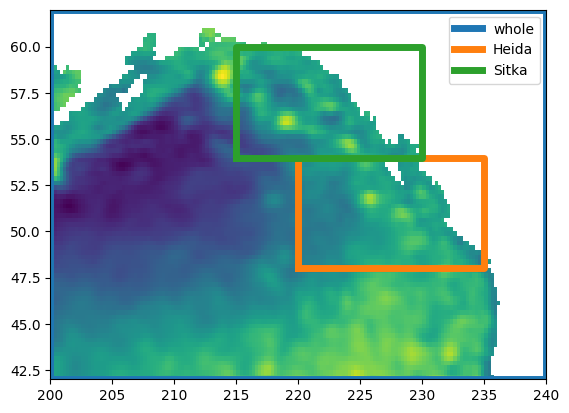

In [15]:
# Display the analysis region
YYYY=2003
MON=6
! rm npp.nc
! rm ssh.nc
DAY=15
date = datetime(YYYY, MON, DAY)
#
get_ssh(YYYY,date,extent)
ds=xr.open_dataset('ssh.nc')
ds
b= [200, 240, 42, 62]
b1=[220, 235, 48, 54]
b2=[215, 230, 54, 60]
lon=ds.longitude
lat=ds.latitude
ssh=ds.adt
plt.pcolormesh(lon,lat,ssh)
plt.plot([b[0],b[1],b[1],b[0],b[0]],[b[2],b[2],b[3],b[3],b[2]],linewidth=5,label='whole')
plt.plot([b1[0],b1[1],b1[1],b1[0],b1[0]],[b1[2],b1[2],b1[3],b1[3],b1[2]],linewidth=5,label='Heida')
plt.plot([b2[0],b2[1],b2[1],b2[0],b2[0]],[b2[2],b2[2],b2[3],b2[3],b2[2]],linewidth=5,label='Sitka')
plt.legend()

In [16]:
# --------------------------------------------------------
# specify input data
# --------------------------------------------------------
Years = np.arange(2003,2022,1)
Months= np.arange(4,10,1)
for n,YYYY in enumerate(Years):
    for m,MON in enumerate(Months):
        ! rm npp.nc
        ! rm ssh.nc
        DAY=15
        date = datetime(YYYY, MON, DAY)
        #
        get_ssh(YYYY,date,extent)
        get_npp(YYYY,date,extent)
        npp = combine_ssh_npp("ssh.nc","npp.nc")
        npp = apply_highpass(npp, Lcutoff)
        a,c = detect_eddies(npp,sshmin,extent,date)
        save_eddyid(a,c,domain,Lcutoff,sshmin)
        anom_a,anom_c=calc_npp_eddy(npp,a,c)
        save_nppstats(anom_a,anom_c,domain,Lcutoff,sshmin)

rm: cannot remove ‘npp.nc’: No such file or directory


We assume pixel position of grid is centered for npp.nc
We assume pixel position of grid is centered for ssh.nc
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
We assume pixel position of grid is centered for npp.nc
We assume pixel position of grid is centered for ssh.nc
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
Data is empty
We assume pixel position of grid is centered for npp.nc
We assume pixel position of grid is centered for

In [17]:
ls 

aggregate.ipynb
Anticyclone_stats.csv
Anticyclonic_20030415.nc
Anticyclonic_20030515.nc
Anticyclonic_20030601.nc
Anticyclonic_20030615.nc
Anticyclonic_20030715.nc
Anticyclonic_20030815.nc
Anticyclonic_20030915.nc
Anticyclonic_20040415.nc
Anticyclonic_20040515.nc
Anticyclonic_20040615.nc
Anticyclonic_20040715.nc
Anticyclonic_20040815.nc
Anticyclonic_20040915.nc
Anticyclonic_20050415.nc
Anticyclonic_20050515.nc
Anticyclonic_20050615.nc
Anticyclonic_20050715.nc
Anticyclonic_20050815.nc
Anticyclonic_20050915.nc
Anticyclonic_20060415.nc
Anticyclonic_20060515.nc
Anticyclonic_20060615.nc
Anticyclonic_20060715.nc
Anticyclonic_20060815.nc
Anticyclonic_20060915.nc
Anticyclonic_20070415.nc
Anticyclonic_20070515.nc
Anticyclonic_20070615.nc
Anticyclonic_20070715.nc
Anticyclonic_20070815.nc
Anticyclonic_20070915.nc
Anticyclonic_20080415.nc
Anticyclonic_20080515.nc
Anticyclonic_20080615.nc
Anticyclonic_20080715.nc
Anticyclonic_20080815.nc
Anticyclonic_20080915.nc
Anticyclonic_20090415.nc
Anticyclonic